# Data Integration

### Setup

In [1]:
import scanpy as sc
import numpy as np
import seaborn as sns
import anndata
import scvi
import os
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"]="1"
DATA_PATH = "/media/gambino/students_workdir/ibp/combined_filtered_counts_13_11.h5"
NORMALIZED_SAMPLES_DATA_PATH = "/media/gambino/students_workdir/ibp/combined_normalizedpersample_qced_filtered_counts_13_11.h5"
NORMALIZED_SAMPLES_GLOBAL_DATA_PATH = "/media/gambino/students_workdir/ibp/combined_normalizedpersampleglobal_qced_filtered_counts_13_11.h5"
NORMALIZED_GLOBAL_DATA_PATH = "/media/gambino/students_workdir/ibp/combined_normalizedglobal_qced_filtered_counts_13_11.h5"

sc.settings.verbosity = 3
sc.logging.print_versions()

/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


-----
anndata     0.10.3
scanpy      1.9.6
-----
Cython                      3.0.5
PIL                         10.1.0
absl                        NA
aiohttp                     3.9.0
aiosignal                   1.3.1
annotated_types             0.6.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backoff                     2.2.1
brotli                      1.0.9
bs4                         4.12.2
certifi                     2023.11.17
cffi                        1.15.1
charset_normalizer          2.0.4
chex                        0.1.7
click                       8.1.7
comm                        0.2.0
contextlib2                 NA
croniter                    NA
cycler                      0.12.1
cython                      3.0.5
cython_runtime              NA
dateutil                    2.8.2
debug

## Loading Data

In [2]:
path_own_scRNADataset = "/media/gambino/students_workdir/ibp/combined_immunerefannotated_markergenes_nodoublets_clustered_normalizedpersampleglobal_qced_filtered_counts_5_12.h5"
adata_immune = sc.read(path_own_scRNADataset)
adata_immune.var['SYMBOL'] = adata_immune.var.index
adata_immune.var.set_index('gene_ids', drop=True, inplace=True)

path_to_scRNAseq = '/media/gambino/students_workdir/ibp/scRNA_data/Full_obj_raw_counts_nosoupx_v2.h5ad'
adata_gut = sc.read(path_to_scRNAseq)
adata_gut.var['SYMBOL'] = adata_gut.var.index
adata_gut.var.set_index('gene_ids', drop=True, inplace=True)
adata_gut.layers["raw_counts"]=adata_gut.X

print("Total number of genes in gut:", len(adata_gut.var_names))
print("Total number of genes in immune:",len(adata_immune.var_names))
print(
    "Number of genes found in query dataset:",
    adata_immune.var_names.isin(adata_gut.var_names).sum(),
)

/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Total number of genes in gut: 33538
Total number of genes in immune: 36601
Number of genes found in query dataset: 32732


In [3]:
adata_gut,adata_immune

(AnnData object with n_obs × n_vars = 428469 × 33538
     obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Gender', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'Integrated_05'
     var: 'feature_types', 'SYMBOL'
     layers: 'raw_counts',
 AnnData object with n_obs × n_vars = 125326 × 36601
     obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'predicted_doublets', 'doublet_scores', 'leiden', 'leiden_0.1', 'leiden_0.3', 'leiden_0.6', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_2.5', 'leiden_3', 'str_predicted_doublets', 'transf_cell_type', 'transf_cell_type_unc', 'transf_cell_type_certain'
     var: 'feature_types', 'genome', 'mt', 'highly_variable', 'means'

In [14]:
import matplotlib.pyplot as plt

def normalize_subset(adata,axes):
    scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
    adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)   
    p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
    axes[0].set_title("Total counts")
    p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
    axes[1].set_title("Shifted logarithm")
    plt.show()
    return adata

In [5]:
selected_immune = sc.AnnData(
    X=adata_immune.X[:, adata_immune.var_names.isin(adata_gut.var_names)],
    obs=adata_immune.obs,
    layers={key: adata_immune.layers[key][:, adata_immune.var_names.isin(adata_gut.var_names)] for key in adata_immune._layers}
)
selected_gut = sc.AnnData(
    X=adata_gut.X[:, adata_gut.var_names.isin(adata_immune.var_names)],
    obs=adata_gut.obs,
    layers={key: adata_gut.layers[key][:, adata_gut.var_names.isin(adata_immune.var_names)] for key in adata_gut._layers}
)

selected_immune.var_names=adata_immune.var_names[adata_immune.var_names.isin(adata_gut.var_names)]
selected_gut.var_names=adata_gut.var_names[adata_gut.var_names.isin(adata_immune.var_names)]
print("Total number of genes in gut:", len(selected_gut.var_names))
print("Total number of genes in immune:",len(selected_immune.var_names))
print(
    "Number of genes found in query dataset:",
    selected_immune.var_names.isin(selected_gut.var_names).sum(),
)
selected_gut,selected_immune

Total number of genes in gut: 32732
Total number of genes in immune: 32732
Number of genes found in query dataset: 32732


(AnnData object with n_obs × n_vars = 428469 × 32732
     obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Gender', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'Integrated_05'
     layers: 'raw_counts',
 AnnData object with n_obs × n_vars = 125326 × 32732
     obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'predicted_doublets', 'doublet_scores', 'leiden', 'leiden_0.1', 'leiden_0.3', 'leiden_0.6', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_2.5', 'leiden_3', 'str_predicted_doublets', 'transf_cell_type', 'transf_cell_type_unc', 'transf_cell_type_certain'
     layers: 'log1p_norm', 'raw_counts')

normalizing counts per cell
    finished (0:00:01)


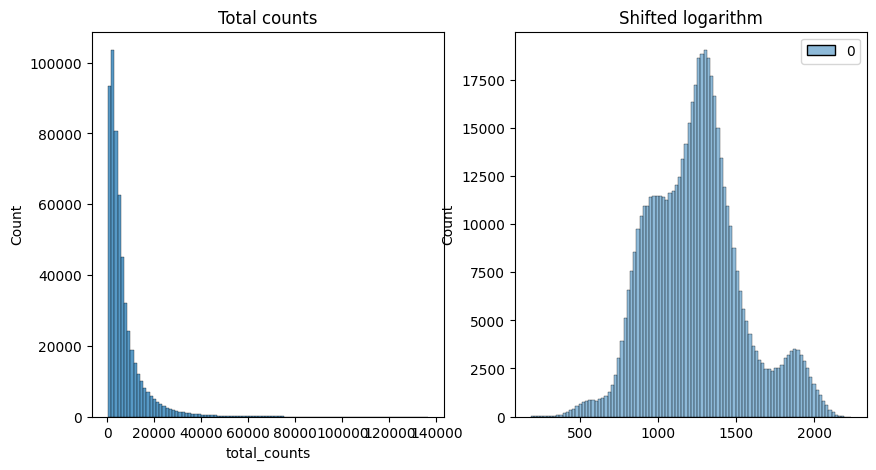

AnnData object with n_obs × n_vars = 553795 × 32732
    obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Gender', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'Integrated_05', 'origin', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt', 'outlier', 'mt_outlier', 'leiden', 'leiden_0.1', 'leiden_0.3', 'leiden_0.6', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_2.5', 'leiden_3', 'str_predicted_doublets', 'transf_cell_type', 'transf_cell_type_unc', 'transf_cell_type_certain'
    layers: 'raw_counts', 'log1p_norm'

In [6]:
selected_gut.obs["origin"] = "gut_atlas"
selected_immune.obs["origin"] = "homemade"
combined = sc.concat(
    [selected_gut, selected_immune],
    axis=0,
    join="outer",
    index_unique=None,
    merge="unique",
)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
normalize_subset(combined,axes)
combined

In [7]:
combined.write("/media/gambino/students_workdir/ibp/combined_homemadeimmuneannotated_humangutatlas.h5")


## Loading Integrated Data

In [4]:
combined=anndata.read("/media/gambino/students_workdir/ibp/combined_homemadeimmuneannotated_humangutatlas.h5")
combined.X=combined.layers["log1p_norm"]

In [5]:
import harmonypy as hm
ho = hm.run_harmony(combined.obsm["X_pca"], combined.obs, ["origin"])

# Write the adjusted PCs to a new file.
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
#res.to_csv("data/adj.tsv.gz", sep = "\t", index = False)

2023-12-13 23:48:55,999 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-12-13 23:51:45,666 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-12-13 23:51:47,141 - harmonypy - INFO - Iteration 1 of 10
2023-12-13 23:54:17,687 - harmonypy - INFO - Iteration 2 of 10
2023-12-13 23:56:46,575 - harmonypy - INFO - Converged after 2 iterations


In [9]:
combined.obsm["X_pca_adj"]=res.T.values

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:46)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:01:31)


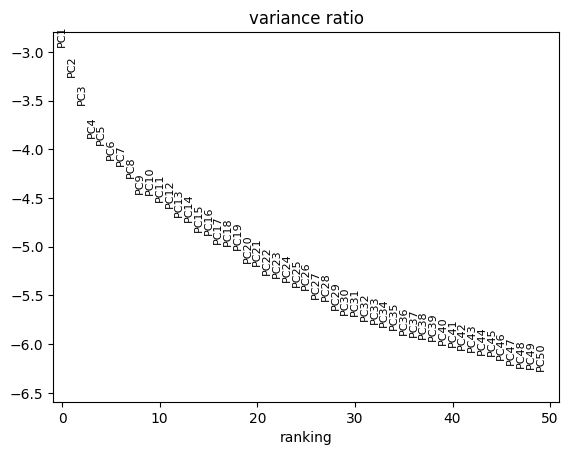

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:20)


In [4]:
sc.pp.highly_variable_genes(combined, flavor="seurat", n_top_genes=2000, inplace=True)
sc.pp.scale(combined, max_value=10)
sc.pp.pca(combined, n_comps=50, use_highly_variable=True)
sc.pl.pca_variance_ratio(combined, log=True, n_pcs=50)
sc.pp.neighbors(combined, n_pcs=40)

In [24]:
combined.write("/media/gambino/students_workdir/ibp/combined_homemadeimmuneannotated_humangutatlas.h5")

computing neighbors
    finished: added to `.uns['adjusted']`
    `.obsp['adjusted_distances']`, distances for each pair of neighbors
    `.obsp['adjusted_connectivities']`, weighted adjacency matrix (0:01:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:05:11)


/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


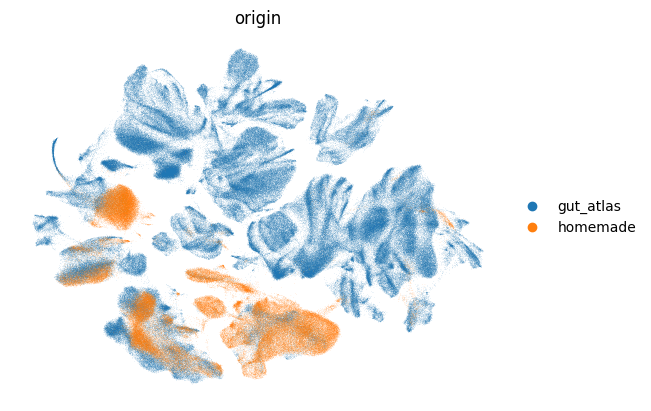

In [11]:
sc.pp.neighbors(combined, n_pcs=50,key_added="adjusted",use_rep="X_pca_adj")
sc.tl.umap(combined,neighbors_key="adjusted")
sc.pl.umap(
    combined,
    color=["origin"],
    sort_order=False,
    frameon=False,
)

In [10]:
sc.tl.umap(combined)
sc.pl.umap(
    combined,
    color=["origin"],
    sort_order=False,
    frameon=False,
)

computing neighbors
    using 'X_pca' with n_pcs = 50


KeyboardInterrupt: 

/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


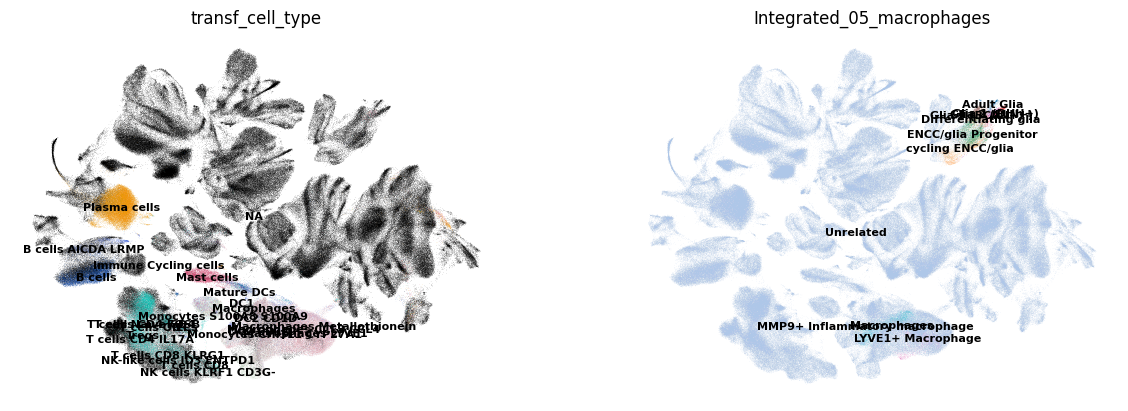

In [12]:
combined.obs["Integrated_05_macrophages"] = combined.obs["Integrated_05"].tolist()
combined.obs.loc[combined.obs["Integrated_05_macrophages"].apply(lambda x: "macrophage" not in str(x).lower() and "glia" not in str(x).lower()  ),"Integrated_05_macrophages"]="Unrelated"
sc.pl.umap(
    combined,
    color=["transf_cell_type","Integrated_05_macrophages"],
    sort_order=False,
    frameon=False,
    legend_loc="on data",
    legend_fontsize=8,
    na_color="black",
)

/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


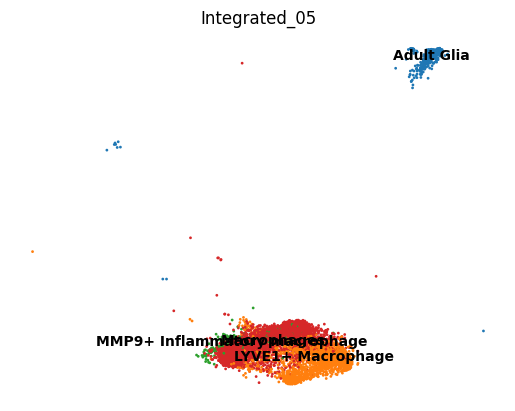

/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


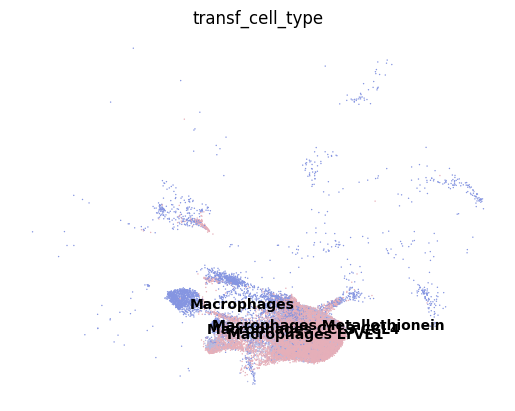

((7594, 32732), (28882, 32732))

In [13]:
macrophages_gut=combined[(combined.obs["category"]=="Myeloid") | (combined.obs["category"]=="Neuronal")][combined[(combined.obs["category"]=="Myeloid") | (combined.obs["category"]=="Neuronal")].obs["Integrated_05"].apply(lambda x: "macrophage" in x.lower() or "adult glia" in str(x).lower())]
macrophages_immune=combined[combined.obs["origin"]=="homemade"][combined[combined.obs["origin"]=="homemade"].obs["transf_cell_type"].apply(lambda x: "macrophage" in x.lower())]
sc.pl.umap(
    macrophages_gut,
    color=["Integrated_05"],
   sort_order=False,
    frameon=False,
    legend_loc="on data",
    legend_fontsize=10,
    na_color="black",
)
sc.pl.umap(
  macrophages_immune,
     color=["transf_cell_type"],
   sort_order=False,
    frameon=False,
    legend_loc="on data",
    legend_fontsize=10,
    na_color="black",
)
macrophages_gut.shape,macrophages_immune.shape

/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


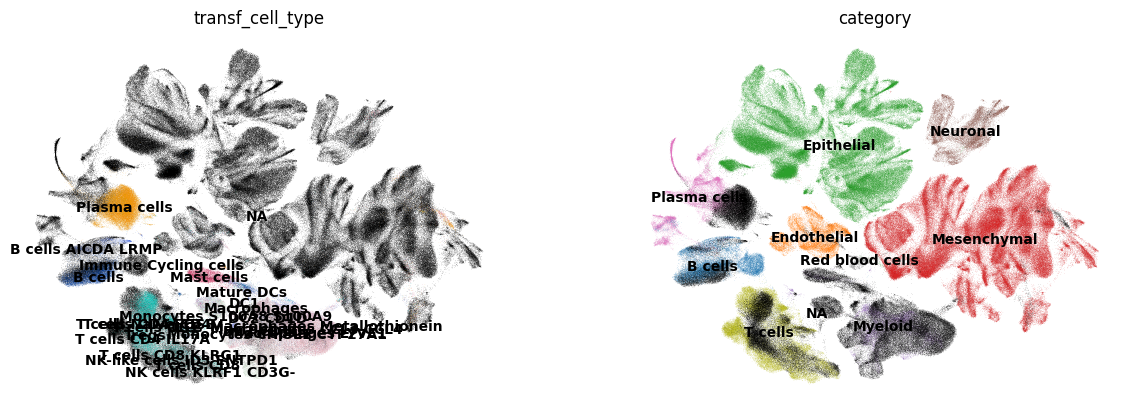

In [14]:
sc.pl.umap(
    combined,
    color=["transf_cell_type","category"],
    sort_order=False,
    frameon=False,
    legend_loc="on data",
    legend_fontsize=10,
    na_color="black",
)

In [15]:
sims_pca={}
from sklearn.metrics.pairwise import cosine_distances
for category1 in macrophages_gut.obs["Integrated_05"].unique():
    cat1=macrophages_gut[macrophages_gut.obs["Integrated_05"]==category1]
    sims_pca[category1]={}
    for category2 in macrophages_immune.obs["transf_cell_type"].unique():
        cat2=macrophages_immune[macrophages_immune.obs["transf_cell_type"]==category2]
        sims_pca[category1][category2]=np.mean(1 - cosine_distances(cat1.obsm["X_pca"],cat2.obsm["X_pca"]))
        print(category1,category2,sims_pca[category1][category2])

MMP9+ Inflammatory macrophage Macrophages LYVE1 0.39109915
MMP9+ Inflammatory macrophage Macrophages CCL3 CCL4 0.4510913
MMP9+ Inflammatory macrophage Macrophages 0.2837828
MMP9+ Inflammatory macrophage Macrophages Metallothionein 0.43167368
LYVE1+ Macrophage Macrophages LYVE1 0.6308107
LYVE1+ Macrophage Macrophages CCL3 CCL4 0.6242443
LYVE1+ Macrophage Macrophages 0.3337706
LYVE1+ Macrophage Macrophages Metallothionein 0.66308177
Adult Glia Macrophages LYVE1 -0.07494714
Adult Glia Macrophages CCL3 CCL4 -0.076361924
Adult Glia Macrophages -0.040460967
Adult Glia Macrophages Metallothionein -0.08341752
Macrophages Macrophages LYVE1 0.4712469
Macrophages Macrophages CCL3 CCL4 0.51503265
Macrophages Macrophages 0.29005274
Macrophages Macrophages Metallothionein 0.50827724


In [21]:
sims_pca={}
from sklearn.metrics.pairwise import cosine_distances
for category1 in macrophages_gut.obs["Integrated_05"].unique():
    cat1=macrophages_gut[macrophages_gut.obs["Integrated_05"]==category1]
    sims_pca[category1]={}
    for category2 in macrophages_immune.obs["transf_cell_type"].unique():
        cat2=macrophages_immune[macrophages_immune.obs["transf_cell_type"]==category2]
        sims_pca[category1][category2]=np.mean(1 - cosine_distances(cat1.obsm["X_pca_adj"],cat2.obsm["X_pca_adj"]))
        print(category1,category2,sims_pca[category1][category2])

MMP9+ Inflammatory macrophage Macrophages LYVE1 0.5785678
MMP9+ Inflammatory macrophage Macrophages CCL3 CCL4 0.6118755
MMP9+ Inflammatory macrophage Macrophages 0.3776248
MMP9+ Inflammatory macrophage Macrophages Metallothionein 0.5484253
LYVE1+ Macrophage Macrophages LYVE1 0.7378592
LYVE1+ Macrophage Macrophages CCL3 CCL4 0.7014668
LYVE1+ Macrophage Macrophages 0.3654161
LYVE1+ Macrophage Macrophages Metallothionein 0.7100778
Adult Glia Macrophages LYVE1 -0.013307489
Adult Glia Macrophages CCL3 CCL4 -0.017207645
Adult Glia Macrophages -0.0027508226
Adult Glia Macrophages Metallothionein -0.030150665
Macrophages Macrophages LYVE1 0.68137074
Macrophages Macrophages CCL3 CCL4 0.69624007
Macrophages Macrophages 0.39141032
Macrophages Macrophages Metallothionein 0.65381384


In [55]:
for category2 in macrophages_immune.obs["transf_cell_type"].unique():
    cat2=macrophages_immune[macrophages_immune.obs["transf_cell_type"]==category2]
    print(category2,np.mean(np.array(cat2.obs["transf_cell_type_unc"].values,dtype=np.float32)))

Macrophages LYVE1 0.37194225
Macrophages CCL3 CCL4 0.52761406
Macrophages 0.5843486
Macrophages Metallothionein 0.55999124


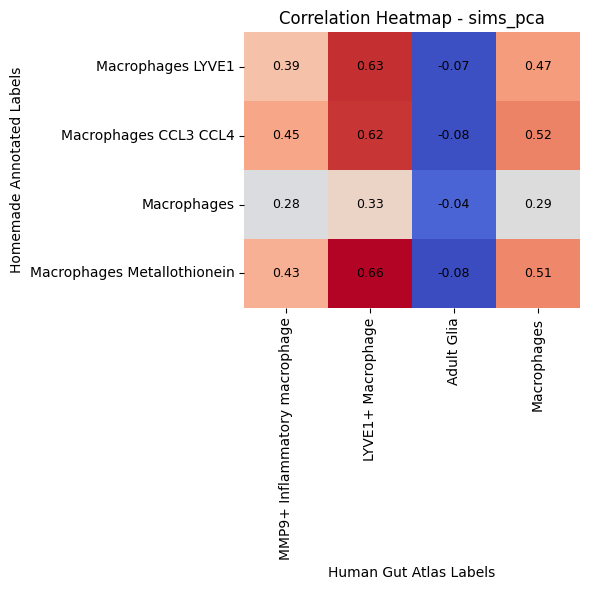

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Create the second heatmap
correlation_matrix_sims_pca = pd.DataFrame(sims_pca)

# Set up subplots
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(correlation_matrix_sims_pca, cmap='coolwarm', fmt='.2f', ax=axes, cbar=False)
axes.set_title('Correlation Heatmap - sims_pca')

# Add correlation values for every spot in the second heatmap
for i in range(len(correlation_matrix_sims_pca)):
    for j in range(len(correlation_matrix_sims_pca.columns)):
        axes.text(j + 0.5, i + 0.5, f"{correlation_matrix_sims_pca.iloc[i, j]:.2f}",
                     ha='center', va='center', color='black', fontsize=9)

axes.set_xlabel('Human Gut Atlas Labels')
axes.set_ylabel('Homemade Annotated Labels')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


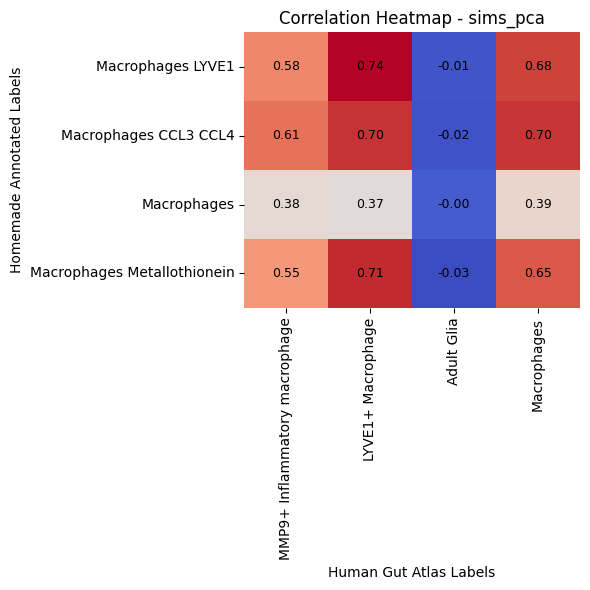

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Create the second heatmap
correlation_matrix_sims_pca = pd.DataFrame(sims_pca)

# Set up subplots
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(correlation_matrix_sims_pca, cmap='coolwarm', fmt='.2f', ax=axes, cbar=False)
axes.set_title('Correlation Heatmap - sims_pca')

# Add correlation values for every spot in the second heatmap
for i in range(len(correlation_matrix_sims_pca)):
    for j in range(len(correlation_matrix_sims_pca.columns)):
        axes.text(j + 0.5, i + 0.5, f"{correlation_matrix_sims_pca.iloc[i, j]:.2f}",
                     ha='center', va='center', color='black', fontsize=9)

axes.set_xlabel('Human Gut Atlas Labels')
axes.set_ylabel('Homemade Annotated Labels')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [29]:
combined.obs["category"].unique()

['B cells', 'T cells', 'Epithelial', 'Mesenchymal', 'Plasma cells', 'Myeloid', 'Endothelial', 'Neuronal', 'Red blood cells', NaN]
Categories (9, object): ['B cells', 'Endothelial', 'Epithelial', 'Mesenchymal', ..., 'Neuronal', 'Plasma cells', 'Red blood cells', 'T cells']

In [169]:
combined.obs["combined_labels"] = combined.obs["category"].tolist()
combined.obs.loc[combined.obs["Integrated_05"]=="Mast cell","combined_labels"]="Mast cells"
combined.obs.loc[combined.obs["Integrated_05"]=="LYVE1+ Macrophage","combined_labels"]="Macrophages LYVE1"
combined.obs.loc[combined.obs["Integrated_05"]=="Monocytes","combined_labels"]="Monocytes"
combined.obs.loc[combined.obs["Integrated_05"]=="Macrophages","combined_labels"]="Macrophages Classical"
combined.obs.loc[combined.obs["Integrated_05"]=="Neuroblast","combined_labels"]="Neuroblast"
combined.obs.loc[combined.obs["Integrated_05"].str.lower()=="adult glia","combined_labels"]="Adult Glia"
combined.obs.loc[combined.obs["Integrated_05"]=="MPO+ mono-neutrophil","combined_labels"]="MPO+ mono-neutrophil"
combined.obs.loc[combined.obs["Integrated_05"].str.lower().isin(['branch b1 (emn)',
 'branch b3 (ipan)',
 'branch a4 (in)',
 'branch a1 (imn)',
 'branch b2 (emn)',
 'branch a2 (ipan/in)',
 'branch a3 (ipan/in)']),"combined_labels"]="branch neurons"
combined.obs.loc[combined.obs["Integrated_05"].str.lower()=="megakaryocyte","combined_labels"]="megakaryocyte"
combined.obs.loc[combined.obs["transf_cell_type"].isin(['T cells CD8 KLRG1',
 'Tregs',
 'T cells CD4 FOSB',
 'T cells Naive CD4',
 'T cells CD8',
 'NK-like cells ID3 ENTPD1',
 'T cells OGT',
 'T cells CD4 IL17A']),"combined_labels"]="T cells"
combined.obs.loc[combined.obs["transf_cell_type"]=="Macrophages LYVE1","combined_labels"]="Macrophages LYVE1"
combined.obs.loc[combined.obs["transf_cell_type"].isin(['DC2 CD1D', 'DC2 CD1D-', 'DC1', 'Mature DCs']),"combined_labels"]="Dendritic cells"
combined.obs.loc[combined.obs["transf_cell_type"]=="Mast cells","combined_labels"]="Mast cells"
combined.obs.loc[combined.obs["transf_cell_type"].isin(['Monocytes S100A8 S100A9', 'Monocytes CHI3L1 CYP27A1']),"combined_labels"]="Monocytes"
combined.obs.loc[combined.obs["transf_cell_type"].isin(['B cells', 'B cells AICDA LRMP']),"combined_labels"]="B Cells"
combined.obs.loc[combined.obs["transf_cell_type"]=="Immune Cycling cells","combined_labels"]="Immune Cycling cells"
combined.obs.loc[combined.obs["transf_cell_type"].isin(['ILCs','NK cells KLRF1 CD3G-', 'NK-like cells ID3 ENTPD1']),"combined_labels"]="ILCs"
combined.obs.loc[combined.obs["transf_cell_type"]=="Macrophages","combined_labels"]="Macrophages Subcelltype"
combined.obs.loc[combined.obs["transf_cell_type"]=="Macrophages Metallothionein","combined_labels"]="Macrophages Metallothionein"
combined.obs.loc[combined.obs["transf_cell_type"]=="Macrophages CCL3 CCL4","combined_labels"]="Macrophages CCL3 CCL4"
combined.obs.loc[combined.obs["transf_cell_type"]=="Plasma cells","combined_labels"]="Plasma cells"
combined.obs.loc[combined.obs["Integrated_05"]=="MMP9+ Inflammatory macrophage","combined_labels"]="MMP9+ Inflammatory macrophage"
combined.obs.loc[combined.obs["Integrated_05"]=="CLC+ Mast cell","combined_labels"]="Mast cells"
combined.obs.loc[combined.obs["Integrated_05"].isin(['cDC2', 'cDC1', 'Lymphoid DC', 'pDC']),"combined_labels"]="Dendritic cells"

In [170]:
print(combined.obs["combined_labels"].unique())

['B cells' 'T cells' 'Epithelial' 'Mesenchymal' 'Plasma cells'
 'MMP9+ Inflammatory macrophage' 'Dendritic cells' 'Endothelial'
 'Mast cells' 'Macrophages LYVE1' 'Monocytes' 'Adult Glia'
 'Macrophages Classical' 'branch neurons' 'Neuronal' 'Neuroblast'
 'MPO+ mono-neutrophil' 'Red blood cells' 'megakaryocyte'
 'Macrophages CCL3 CCL4' 'Macrophages Subcelltype' 'B Cells'
 'Immune Cycling cells' 'ILCs' 'Macrophages Metallothionein']


/media/gambino/students_workdir/anis/miniconda3/envs/ibp-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


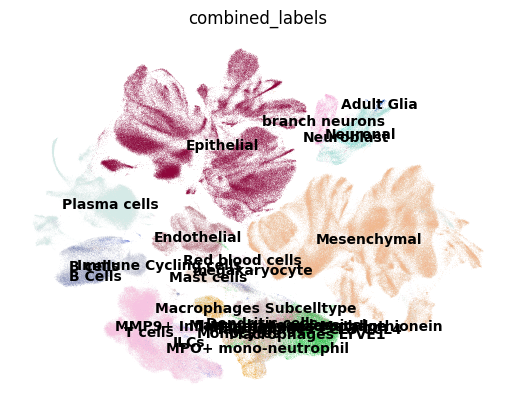

In [172]:
sc.pl.umap(
    combined,
    color=["combined_labels"],
    sort_order=False,
    frameon=False,
    legend_loc="on data",
    legend_fontsize=10,
    na_color="black",
)

In [173]:
combined.write("/media/gambino/students_workdir/ibp/combined_homemadeimmuneannotated_humangutatlas.h5")

### Analysis of Adult Glia vs Macrophages

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden_0.3', method='wilcoxon', key_added='rank_leiden_0.3')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key='rank_leiden_0.3')

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden_0.3', groups=[7], ref=[6], method='wilcoxon', 
                        key_added='rank_selgroups_leiden_0.3')

In [ ]:
df_rank_cur_cluster = sc.get.rank_genes_groups_df(adata, '0', key='rank_leiden_0.3_filtered', 
                                                  log2fc_min=2, pval_cutoff=0.05)
sel_genes = [ gene for gene in df_rank_cur_cluster.dropna()['names'] ]
sc.queries.enrich( sel_genes, org='hsapiens').head(n=10)